In [1]:
pip install folium

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pystan==2.19.1.1 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install fbprophet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Time series Using Facebook Prophet

In [1]:
#Exploratory 
import pandas as pd
import numpy as np

#Data Visualization 
import seaborn as sns
import folium

#Data Modeling / Forecasting 
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

#Data Evaluation 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ignore any warnings
import warnings;
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)


### Loading the data

In [2]:
df= pd.read_csv('Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_month.csv')

In [3]:
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,...,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31
0,102001,0,United States,country,NaN,108664.065693,108495.494517,108555.058209,108761.899002,109009.495097,...,322294.903229,327445.958954,332276.511803,338073.685771,344114.638771,350589.406051,354792.169033,357548.351856,357182.219270,356054.144014
1,394913,1,"New York, NY",msa,NY,188522.820365,186806.224260,186420.908986,186104.869066,185996.861284,...,575267.147045,577807.454168,582817.142771,588435.263286,598608.991473,607579.894997,615367.659459,619631.968470,621217.321721,620145.992454
2,753899,2,"Los Angeles, CA",msa,CA,186551.889182,185884.482490,185593.319105,185569.693864,185438.928720,...,861881.417343,874279.766711,887482.195789,901725.929478,930753.289617,950143.551902,955173.672577,932992.372762,929100.238917,897864.418850
3,394463,3,"Chicago, IL",msa,IL,147298.360904,147297.582443,146377.081265,147798.200258,148327.514646,...,290219.041432,291912.354888,294727.188283,298579.504671,303986.860603,308710.789295,313939.515379,314991.250548,314085.644474,312486.729429
4,394514,4,"Dallas, TX",msa,TX,113332.216364,113247.780650,113568.228432,114097.096793,114336.579284,...,344557.976761,351337.021321,360033.614446,370611.636209,376683.966527,391864.985419,399785.127705,401427.284760,397074.412395,391567.470647


### Filtering data for Colorado

In [4]:
# Overwrite dataframe to have NY state only
df = df[df['StateName']=='CO']
#Check for missing values
df.isnull().sum()

RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     0
             ..
2022-04-30    0
2022-05-31    0
2022-06-30    0
2022-07-31    0
2022-08-31    0
Length: 325, dtype: int64

In [5]:
# Fill missing values with backfilling 
df.fillna(method='bfill', inplace=True)

In [6]:
# See Regions
df['RegionName'].value_counts()

Fort Morgan, CO          1
Ca-¦on City, CO          1
Denver, CO               1
Boulder, CO              1
Montrose, CO             1
Durango, CO              1
Steamboat Springs, CO    1
Sterling, CO             1
Fort Collins, CO         1
Pueblo, CO               1
Colorado Springs, CO     1
Breckenridge, CO         1
Edwards, CO              1
Grand Junction, CO       1
Craig, CO                1
Greeley, CO              1
Glenwood Springs, CO     1
Name: RegionName, dtype: int64

## Data Preprocessing
### Creating Statistical Columns
 Create ROI, Standard Deviation and Mean

In [7]:
#Calculate ROI percentage

#df['ROI']= ( (df['2022-08-31']/df['1996-01-31'])-1 ) *100 
#or
df['ROI']= (  (df['2022-08-31']-df['1996-01-31'])/df['1996-01-31'] ) *100 

#Calculate standard deviation of monthly values
df['std']=df.loc[:,'1996-01-31':'2022-08-31'].std(skipna=True, axis=1)

#Calculate historical mean value
df['mean']=df.loc[:,'1996-01-31':'2022-08-31'].mean(skipna=True, axis=1)

In [8]:
# Show the first 5 rows of the new data
df[['std','mean','ROI']].head()

,std,mean,ROI
19,111108.112534,293039.981651,330.305877
79,75482.421338,230806.496140,265.664369
149,94352.212207,284242.444156,251.594595
153,85291.913532,260689.939951,255.790396
155,141761.964194,380591.128113,320.553082


### Reshape from Wide to Long Format

In [9]:
#cleaning melted dataFrame column RegionName
df['RegionName'] = df['RegionName'].apply(lambda x: x[:-4] )
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,...,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,ROI,std,mean
19,394530,19,Denver,msa,CO,145065.622496,146030.620726,146745.439407,147501.011621,148330.325355,...,622796.196568,640199.990044,649573.150714,652142.268156,642781.053431,631267.381249,624225.899375,330.305877,111108.112534,293039.981651
79,394484,79,Colorado Springs,msa,CO,132291.692435,132815.081731,133682.580734,135026.457851,136158.258653,...,477063.725158,483813.069221,496041.386784,499643.477315,497414.431265,489281.161782,483743.582969,265.664369,75482.421338,230806.496140
149,394602,150,Fort Collins,msa,CO,163054.547633,163379.548768,164205.539638,164822.593773,165049.071541,...,557736.786316,569959.863902,584232.957037,593945.084179,590380.263583,580574.954966,573290.975791,251.594595,94352.212207,284242.444156
153,394645,154,Greeley,msa,CO,150823.586191,153002.693085,153290.139058,157912.933725,158418.911950,...,520201.328693,530025.273275,541968.538779,542155.836979,540473.311000,538597.812077,536615.834182,255.790396,85291.913532,260689.939951
155,394405,156,Boulder,msa,CO,188318.036345,188652.082514,188612.102688,188625.045872,189459.087320,...,776429.364803,805319.442582,825548.384030,836760.128692,811971.362327,796111.174744,791977.304893,320.553082,141761.964194,380591.128113


In [10]:
#Drop columns we dont need
df.drop(['RegionID', 'SizeRank'], axis=1,inplace=True)

In [11]:
# Melt function takes in the long shape dataFrame and returns a short shape dataFrame

def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName','RegionType', 'StateName','ROI','std','mean'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [12]:
df_melted = melt_data(df)

### Sorting by hightest ROI by Exploratory Data Analysis

In [13]:

top_5_metro = df_melted.loc[df_melted.groupby("RegionName")["ROI"].\
              idxmax()].sort_values('ROI',
                                    ascending=False)[:5]
top_5_metro.reset_index(drop = 1)

,RegionName,RegionType,StateName,ROI,std,mean,time,value
0,Breckenridge,msa,CO,548.770560,192526.569818,408453.321434,1996-01-31,160586.202440
1,Steamboat Springs,msa,CO,507.293830,168845.419920,395419.328480,1996-01-31,160586.202440
2,Edwards,msa,CO,420.293444,197664.986835,548848.405998,1996-01-31,244453.882796
3,Glenwood Springs,msa,CO,381.817674,141748.112521,379768.053333,1996-01-31,166928.562519
4,Montrose,msa,CO,341.799984,69992.883209,200949.404019,1996-01-31,95009.593917


### Writing the functions to forecast 1 year into the future and return the ROI percentage

#### Facebook forecast:

In [14]:
def Facebook(city):
    """ 
    Takes a city and melts it into a dataframe:
    returns the Facebook forecasts plots
    """
    #Melting city
    city_df = df[df['RegionName'] == city]
    city_melted = melt_data(city_df)
    
    #Facebook df with ds for time and y for value
    city_melted['ds']= city_melted['time']
    city_melted['y']= city_melted['value']
    city_melted = city_melted[['ds','y']].reset_index()
    
    #instantiate
    prophet_model = Prophet()
    prophet_model.fit(city_melted)
    #forecast on future
    future = prophet_model.make_future_dataframe(freq ='MS', periods=12)
    forecast = prophet_model.predict(future)
    # Define prophet ROI
    prophet_ROI = ( ((forecast.yhat.iloc[-1]) - (forecast.yhat.iloc[-12]))/(forecast.yhat.iloc[-12]) ) * 100
    
    fig1 = prophet_model.plot(forecast)
    fig2 = prophet_model.plot_components(forecast)
    fig3 = plot_plotly(prophet_model, forecast)
    fig4 = plot_components_plotly(prophet_model, forecast)

    return None
    

#### Facebook Return of Investment (ROI)

In [15]:
def Facebook_ROI(city):
    """ 
    Takes a city and melts it into a dataframe:
    returns the Facebook forecast ROI
    """
    #Melting city
    city_df = df[df['RegionName'] == city]
    city_melted = melt_data(city_df)
    
    #Facebook df with ds for time and y for value
    city_melted['ds']= city_melted['time']
    city_melted['y']= city_melted['value']
    city_melted = city_melted[['ds','y']].reset_index()
    #Indicate from what year 
    #city_melted = city_melted[city_melted['ds'] > '2000']
    
    #instantiate
    prophet_model = Prophet()
    prophet_model.fit(city_melted)
    #forecast on future
    future = prophet_model.make_future_dataframe(freq ='MS', periods=12)
    forecast = prophet_model.predict(future)
    
    # Define prophet ROI
    prophet_ROI = ( ((forecast.yhat.iloc[-1]) - (forecast.yhat.iloc[-12]))/(forecast.yhat.iloc[-12]) ) * 100
    
    return prophet_ROI
    

In [16]:
# List comprehension to pass all 17 cities to the fuction Facebook_ROI()
cities = [x for x in df['RegionName']]
cities_ROI = [Facebook_ROI(i) for i in cities]
ROI_list = dict(zip(cities,cities_ROI))
print(ROI_list)

{'Denver': 6.574985995200754, 'Colorado Springs': 7.679500746246186, 'Fort Collins': 5.8008167692272306, 'Greeley': 6.2768078645513645, 'Boulder': 6.05055995600252, 'Pueblo': 8.684706667579189, 'Grand Junction': 6.789518533197539, 'Glenwood Springs': 6.046921961010361, 'Durango': 7.7984708564973175, 'Edwards': -1.6124515149700096, 'Montrose': 6.47446388778982, 'Ca-¦on City': 5.6913513639902025, 'Breckenridge': 8.520055894555046, 'Fort Morgan': 4.719755402025446, 'Steamboat Springs': 7.0981871142156265, 'Sterling': 5.299139831849539, 'Craig': 3.183603485744512}


### Checking cities with Highest ROI fromFacebook Probhet and comparing to ARIMA model

In [17]:
#Sort Cities by Highest ROI from the Facebook Prophet
data = dict(ROI_list)
pd.DataFrame.from_dict(data, orient='Index').sort_values(by = 0, ascending=False).reset_index().head(5)

,index,0
0,Pueblo,8.684707
1,Breckenridge,8.520056
2,Durango,7.798471
3,Colorado Springs,7.679501
4,Steamboat Springs,7.098187


In [18]:
Facebook_ROI('Pueblo')

8.684706667579189

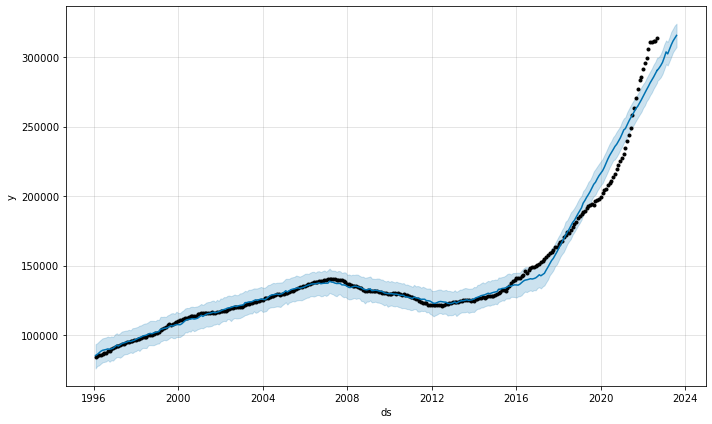

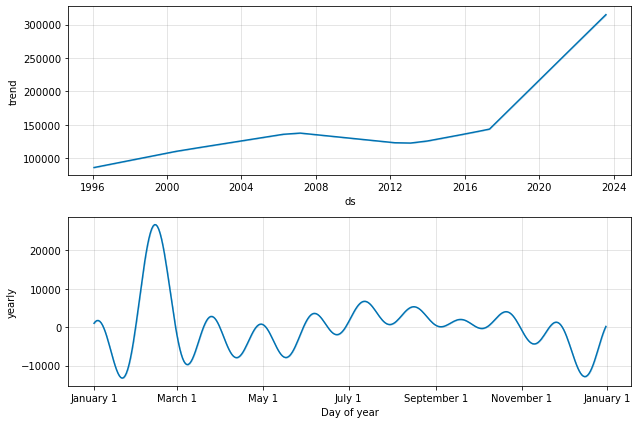

In [19]:
Facebook('Pueblo')

In [20]:
Facebook_ROI('Breckenridge')

8.520055894555046

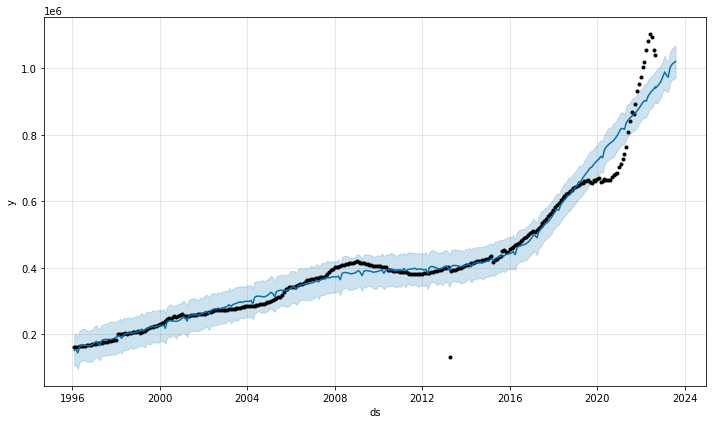

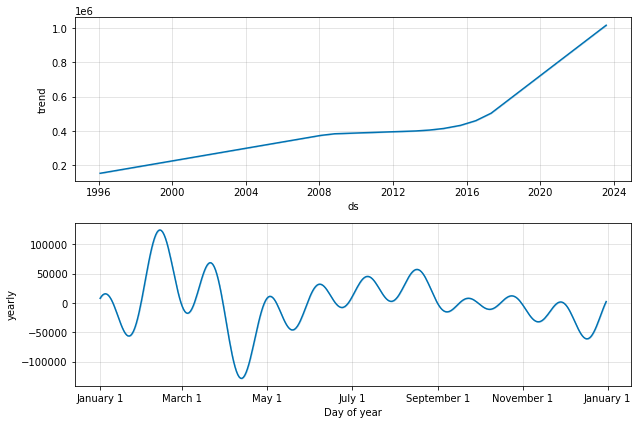

In [21]:
Facebook ('Breckenridge')

In [22]:
Facebook_ROI('Durango')

7.7984708564973175

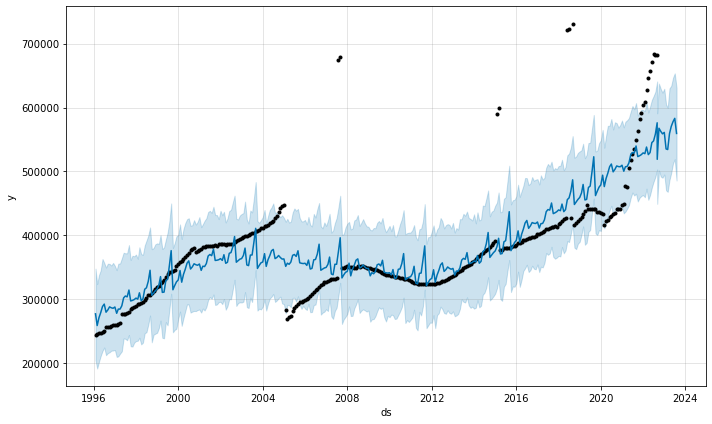

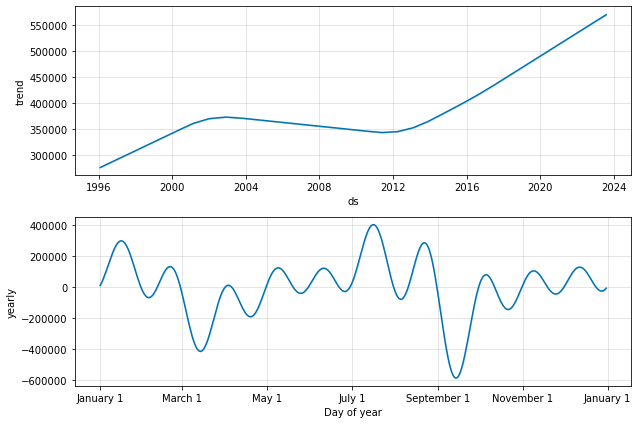

In [23]:
Facebook ('Durango')

In [24]:
Facebook_ROI ('Colorado Springs')

7.679500746246186

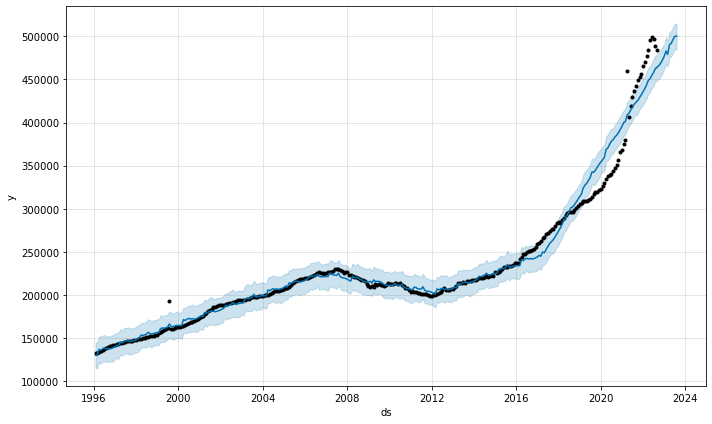

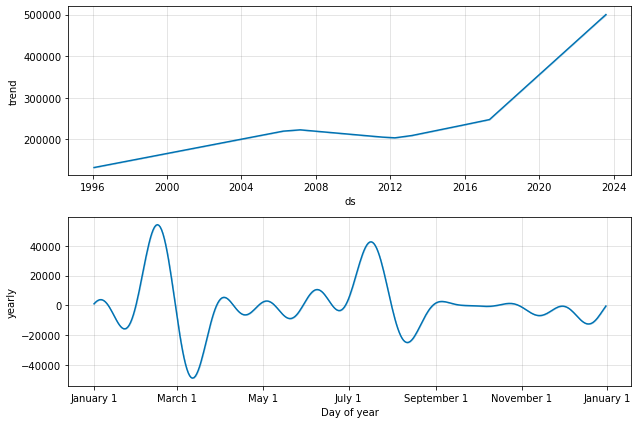

In [25]:
Facebook('Colorado Springs')

In [26]:
Facebook_ROI('Steamboat Springs')

7.0981871142156265

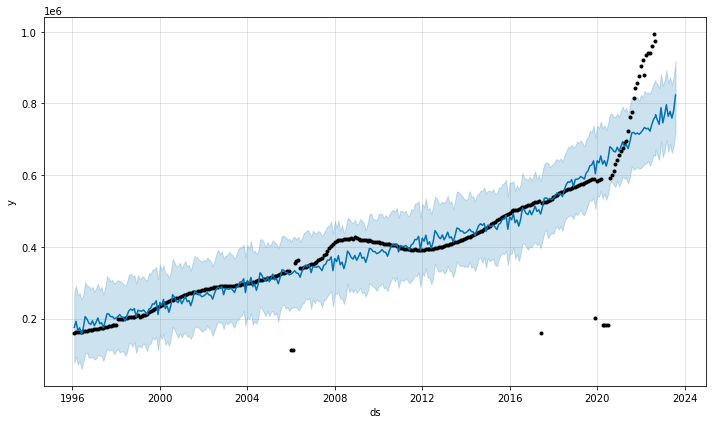

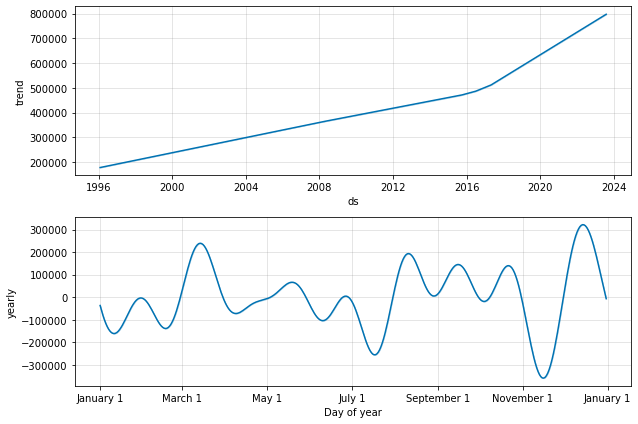

In [27]:
Facebook('Steamboat Springs')